In [1]:
# Imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

from CustomCNNSegmentation import SimpleResNetSegmentation
from CustomCNN import CustomCNN

In [2]:
dataset_type = 'large'
data = torch.load(f'./data/segmentation_custom_dataset/{dataset_type}_segmentation.pth')
images = data['images'].float() 
masks = data['labels'].float() 

In [3]:
print(masks.shape)
print(images.shape)

torch.Size([100, 224, 224])
torch.Size([100, 224, 224])


In [4]:
# Create dataset
dataset = TensorDataset(images.unsqueeze(1), masks)  # Add channel dimension

# Split dataset: 70% for training and 20% for validation/testing
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataloaders
batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Placeholders for metrics
train_losses = []
test_losses = []
test_accuracies = []

In [6]:
# Defining IOU to use as metric
def iou_metric(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

In [7]:
# Model Initialization
model = SimpleResNetSegmentation(num_classes=2).cuda()  # Assuming you're using a GPU

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)


# Training loop
num_epochs = 25
train_losses = []
test_losses = []
test_ious = []

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()  # .cuda() if using GPU
        labels = labels.squeeze(1).long()  # Adjusting the shape of labels for CrossEntropyLoss

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:  # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    
    # Calculate training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validate the model
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    total_iou = 0.0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            labels = labels.squeeze(1).long()  # Adjusting the shape of labels for CrossEntropyLoss
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_iou += iou_metric(labels.float(), predicted.float())
    
    avg_test_loss = test_loss / len(test_loader)
    scheduler.step(avg_test_loss)
    
    avg_iou = total_iou / len(test_loader)
    test_ious.append(avg_iou.cpu())

    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Test Loss: {avg_test_loss:.4f} Test IoU: {avg_iou:.4f}')

Epoch [1/25] Train Loss: 0.9745 Test Loss: 0.4670 Test IoU: 0.0000
Epoch [2/25] Train Loss: 0.3593 Test Loss: 0.1313 Test IoU: 0.0026
Epoch [3/25] Train Loss: 0.0772 Test Loss: 0.0241 Test IoU: 0.6970
Epoch [4/25] Train Loss: 0.0276 Test Loss: 0.0200 Test IoU: 0.7363
Epoch [5/25] Train Loss: 0.0211 Test Loss: 0.0163 Test IoU: 0.7968
Epoch [6/25] Train Loss: 0.0166 Test Loss: 0.0126 Test IoU: 0.8415
Epoch [7/25] Train Loss: 0.0128 Test Loss: 0.0084 Test IoU: 0.8708
Epoch [8/25] Train Loss: 0.0094 Test Loss: 0.0082 Test IoU: 0.8818
Epoch [9/25] Train Loss: 0.0079 Test Loss: 0.0058 Test IoU: 0.8978
Epoch [10/25] Train Loss: 0.0065 Test Loss: 0.0052 Test IoU: 0.8962
Epoch [11/25] Train Loss: 0.0055 Test Loss: 0.0045 Test IoU: 0.9071
Epoch [12/25] Train Loss: 0.0047 Test Loss: 0.0040 Test IoU: 0.9233
Epoch [13/25] Train Loss: 0.0040 Test Loss: 0.0036 Test IoU: 0.9238
Epoch [14/25] Train Loss: 0.0035 Test Loss: 0.0033 Test IoU: 0.9199
Epoch [15/25] Train Loss: 0.0032 Test Loss: 0.0031 Test I

In [8]:
# Saving model
torch.save(model.state_dict(), f'./Models/custom_cnn_segmentation_{dataset_type}_withoutbn.pth')

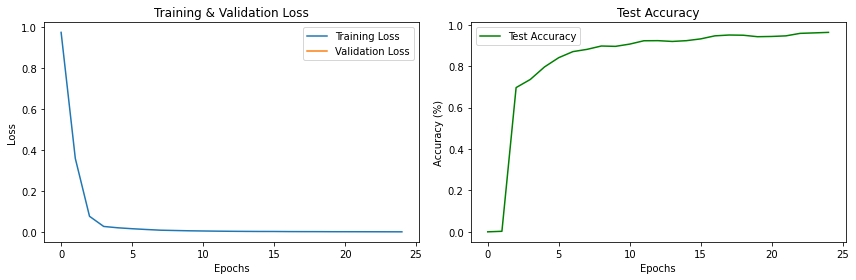

In [9]:
# 4. Plotting metrics
plt.figure(figsize=(12, 4))

# Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
_ = plt.legend()

# Test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_ious, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
_ = plt.legend()

_ = plt.tight_layout()
_ = plt.show()

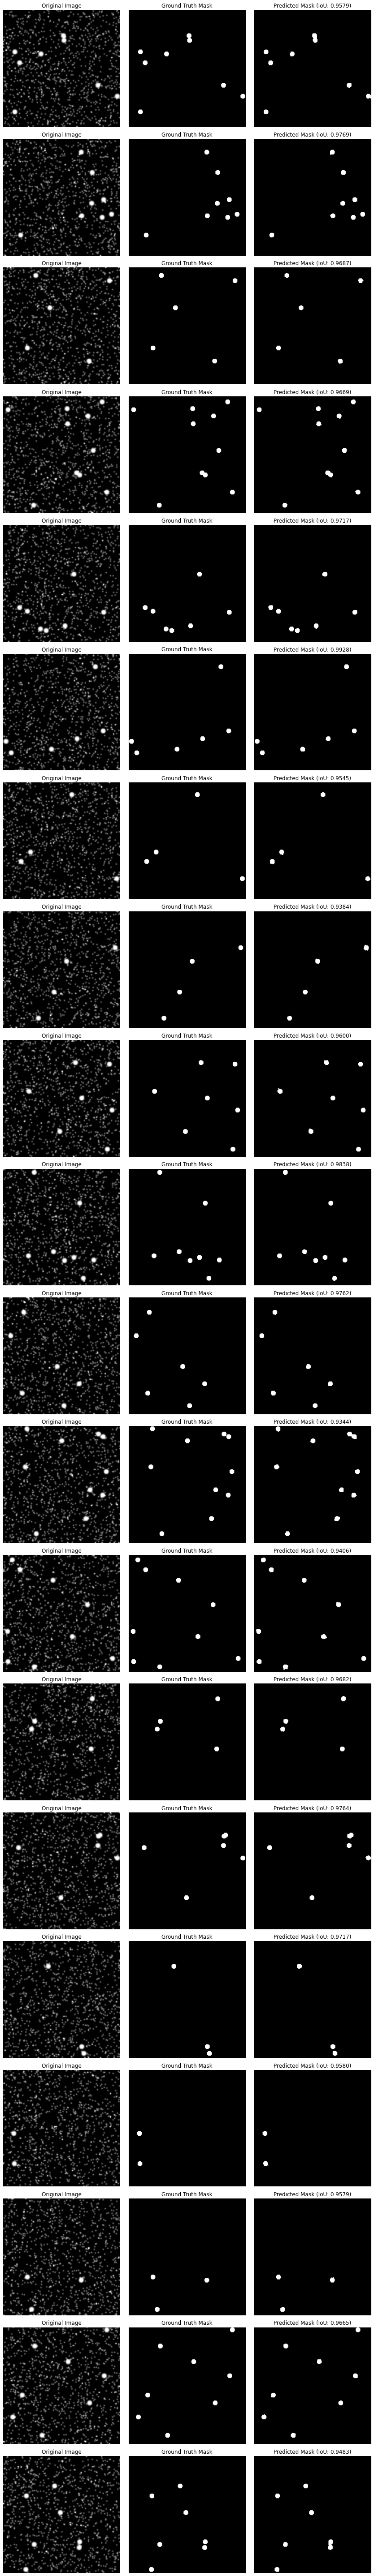

In [10]:
model.eval()

# Select a random batch from the test dataset
images, masks = next(iter(test_loader))
if torch.cuda.is_available():
    images, masks = images.cuda(), masks.cuda()

# Get model predictions
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Plot the results
fig, axs = plt.subplots(len(images), 3, figsize=(12, len(images)*4))
for idx, (img, mask, pred) in enumerate(zip(images, masks, preds)):
    mask_np = mask.squeeze().cpu().numpy()
    pred_np = pred.squeeze().cpu().numpy()
    
    iou_score = iou_metric(mask_np, pred_np)
    
    axs[idx, 0].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axs[idx, 0].set_title('Original Image')
    
    axs[idx, 1].imshow(mask_np, cmap='gray')
    axs[idx, 1].set_title('Ground Truth Mask')
    
    axs[idx, 2].imshow(pred_np, cmap='gray')
    axs[idx, 2].set_title(f'Predicted Mask (IoU: {iou_score:.4f})')

for ax in axs.ravel():
    ax.axis('off')

plt.tight_layout()
plt.show()